# Local SwinUNetR Training Experiments

This notebook provides a complete training pipeline for SwinUNetR models (baseline and SwiGLU+ReLU² variants) using the CellSeg3D training infrastructure.

**Features:**
- Works locally (no Colab-specific code)
- Supports both baseline SwinUNetR and SwinUNetR_SwiGLU_ReLU2
- Uses CellSeg3D Zenodo dataset
- Clean training + evaluation pipeline
- Easy to port to Colab later


## 1. Environment & Imports

**Note:** If you get a "No Qt bindings could be found" error, install Qt bindings first:
```bash
pip install PySide6
```
Then restart the kernel and run the cells again.


In [ ]:
import sys
from pathlib import Path
import json
import pickle
from typing import List, Optional, Dict

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for Qt bindings (required by CellSeg3D)
def check_qt_bindings():
    """Check if Qt bindings are available."""
    try:
        import PySide6
        return "PySide6"
    except ImportError:
        try:
            import PyQt6
            return "PyQt6"
        except ImportError:
            try:
                import PySide2
                return "PySide2"
            except ImportError:
                try:
                    import PyQt5
                    return "PyQt5"
                except ImportError:
                    return None

qt_binding = check_qt_bindings()
if qt_binding is None:
    print("⚠ Qt bindings not found. CellSeg3D requires Qt for some imports.")
    print("  Installing PySide6 (recommended for notebooks)...")
    print("  Run this in a terminal:")
    print("    pip install PySide6")
    print("\n  Or install PyQt5:")
    print("    pip install PyQt5")
    print("\n  After installing, restart the kernel and run this cell again.")
    raise ImportError(
        "Qt bindings required. Install with: pip install PySide6"
    )
else:
    print(f"✓ Qt bindings found: {qt_binding}")

# Add repo root and submodules to path
repo_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
cellseg3d_path = repo_root / "cellseg3d"
cell_observatory_finetune_path = repo_root / "cell_observatory_finetune"
cell_observatory_platform_path = repo_root / "cell_observatory_platform"

# Remove any conflicting paths (like parent directories that might have cell_observatory_finetune)
# Check if Downloads is in path and remove it if it's not our repo_root
downloads_path = repo_root.parent
conflicting_paths = []
if str(downloads_path) in sys.path:
    conflicting_paths.append(str(downloads_path))
    sys.path.remove(str(downloads_path))
    print(f"⚠ Removed conflicting path: {downloads_path}")

# Also remove any other paths that might have cell_observatory_finetune
# (like paths added by CellSeg3D wrapper)
for path in list(sys.path):  # Make a copy to iterate over
    if path != str(repo_root) and path != str(cellseg3d_path):
        # Check if this path would lead to a different cell_observatory_finetune
        test_path = Path(path) / "cell_observatory_finetune"
        if test_path.exists() and test_path != cell_observatory_finetune_path:
            if path not in conflicting_paths:
                conflicting_paths.append(path)
                sys.path.remove(path)
                print(f"⚠ Removed conflicting path: {path}")

# Clear module cache if cell_observatory_finetune was already imported from wrong location
if 'cell_observatory_finetune' in sys.modules:
    del sys.modules['cell_observatory_finetune']
    # Also clear any submodules
    modules_to_remove = [m for m in sys.modules.keys() if m.startswith('cell_observatory_finetune')]
    for m in modules_to_remove:
        del sys.modules[m]
    print(f"✓ Cleared cell_observatory_finetune from module cache")

# Install and register TIFF reader with MONAI (needed for training worker to load TIFF files)
try:
    import tifffile
    print("✓ tifffile available")
except ImportError:
    print("⚠ tifffile not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tifffile", "imagecodecs"], 
                         stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    import tifffile
    print("✓ tifffile installed")

# Patch MONAI's LoadImage to use tifffile for TIFF files
# This ensures the training worker can load TIFF files
try:
    from monai.transforms.io.array import LoadImage
    
    # Store original __call__ method
    original_call = LoadImage.__call__
    
    def patched_call(self, filename, reader=None):
        """Patched LoadImage that uses tifffile for .tif/.tiff files.
        Returns a plain array (not (array, meta)) so downstream code like
        `LoadImaged(keys=["label"])` sees `check_labels["label"]` as an array,
        not a tuple.
        """
        filename_str = str(filename)
        if filename_str.lower().endswith(('.tif', '.tiff')):
            try:
                # Try tifffile directly
                img = tifffile.imread(filename_str)
                # Return just the image array; MONAI wrappers will handle metadata
                return img
            except Exception:
                # Fall back to original loader
                return original_call(self, filename, reader)
        else:
            # Use original for non-TIFF files
            return original_call(self, filename, reader)
    
    # Patch the method
    LoadImage.__call__ = patched_call
    print("✓ Patched MONAI LoadImage to use tifffile for TIFF files")
except Exception as e:
    print(f"⚠ Could not patch LoadImage: {e}")
    print("  Training may fail if MONAI can't read TIFF files")
    print("  Try: pip install monai[tifffile] or pip install tifffile imagecodecs")

# Mock nvidia.dali module if not available (needed for cell_observatory_platform but not used by CellSeg3D)
try:
    import nvidia.dali
except ImportError:
    print("⚠ nvidia.dali not found - creating mock (not needed for CellSeg3D training)")
    import types
    
    # Create mock nvidia module
    nvidia_module = types.ModuleType('nvidia')
    nvidia_dali_module = types.ModuleType('nvidia.dali')
    nvidia_dali_plugin_module = types.ModuleType('nvidia.dali.plugin')
    nvidia_dali_plugin_pytorch_module = types.ModuleType('nvidia.dali.plugin.pytorch')
    
    # Create mock types for DALI_DTYPES enum
    class MockDALITypes:
        UINT16 = "UINT16"
        FLOAT16 = "FLOAT16"
        FLOAT = "FLOAT"
    
    nvidia_dali_module.types = MockDALITypes()
    
    # Create mock fn module (used in some transforms)
    nvidia_dali_fn_module = types.ModuleType('nvidia.dali.fn')
    nvidia_dali_module.fn = nvidia_dali_fn_module
    sys.modules['nvidia.dali.fn'] = nvidia_dali_fn_module
    
    # Add pipeline_def decorator (used in some dataset files)
    def mock_pipeline_def(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    nvidia_dali_module.pipeline_def = mock_pipeline_def
    
    # Create mock DALIGenericIterator class
    class MockDALIGenericIterator:
        pass
    
    nvidia_dali_plugin_pytorch_module.DALIGenericIterator = MockDALIGenericIterator
    
    # Set up module hierarchy
    nvidia_dali_module.plugin = nvidia_dali_plugin_module
    nvidia_dali_plugin_module.pytorch = nvidia_dali_plugin_pytorch_module
    nvidia_module.dali = nvidia_dali_module
    
    # Register in sys.modules
    sys.modules['nvidia'] = nvidia_module
    sys.modules['nvidia.dali'] = nvidia_dali_module
    sys.modules['nvidia.dali.plugin'] = nvidia_dali_plugin_module
    sys.modules['nvidia.dali.plugin.pytorch'] = nvidia_dali_plugin_pytorch_module
    print("✓ Created mock nvidia.dali module")

# Add paths to sys.path in the correct order:
# 1. repo_root first (so cell_observatory_finetune and cell_observatory_platform can be imported as packages)
# 2. cell_observatory_platform (needed by cell_observatory_finetune)
# 3. cellseg3d (so napari_cellseg3d can be found)
# Use insert(0, ...) to ensure they're at the front and checked first
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(cell_observatory_platform_path))
sys.path.insert(0, str(cellseg3d_path))

# Verify paths exist
if not cellseg3d_path.exists():
    print(f"⚠ Warning: cellseg3d directory not found at {cellseg3d_path}")
    print("  Make sure the cellseg3d submodule is initialized:")
    print("  git submodule update --init --recursive")

if not cell_observatory_finetune_path.exists():
    print(f"⚠ Warning: cell_observatory_finetune directory not found at {cell_observatory_finetune_path}")
    print("  Make sure the cell_observatory_finetune module is available")
else:
    print(f"✓ cell_observatory_finetune found at: {cell_observatory_finetune_path}")
    # Verify the model file exists
    model_file = cell_observatory_finetune_path / "models" / "meta_arch" / "swin_unetr_swiglu_relu2.py"
    if model_file.exists():
        print(f"✓ Model file found: {model_file.name}")
    else:
        print(f"⚠ Model file not found: {model_file}")

if not cell_observatory_platform_path.exists():
    print(f"⚠ Warning: cell_observatory_platform directory not found at {cell_observatory_platform_path}")
    print("  Make sure the cell_observatory_platform module is available")
else:
    print(f"✓ cell_observatory_platform found at: {cell_observatory_platform_path}")

# Test import of cell_observatory_finetune model directly
print("Testing direct import of SwinUNETR_SwiGLU_ReLU2...")
print(f"  repo_root in sys.path: {str(repo_root) in sys.path}")
print(f"  repo_root: {repo_root}")
try:
    # Test if we can import the package
    import cell_observatory_finetune
    package_location = cell_observatory_finetune.__file__ if hasattr(cell_observatory_finetune, '__file__') else 'N/A'
    print(f"✓ cell_observatory_finetune package imported")
    print(f"  Location: {package_location}")
    
    # Verify it's from the correct location
    expected_location = str(cell_observatory_finetune_path / "__init__.py")
    if package_location != expected_location:
        raise ImportError(
            f"Package imported from wrong location!\n"
            f"  Expected: {expected_location}\n"
            f"  Got:      {package_location}\n"
            f"  Please restart the kernel and run this cell again."
        )
    
    # Verify the model file exists in the imported package
    import os
    model_file_path = os.path.join(os.path.dirname(package_location), "models", "meta_arch", "swin_unetr_swiglu_relu2.py")
    if not os.path.exists(model_file_path):
        raise ImportError(
            f"Model file not found at expected location!\n"
            f"  Expected: {model_file_path}\n"
            f"  Package location: {package_location}"
        )
    print(f"✓ Model file verified at: {model_file_path}")
    
    # Test the specific model import
    from cell_observatory_finetune.models.meta_arch.swin_unetr_swiglu_relu2 import SwinUNETR_SwiGLU_ReLU2
    print("✓ SwinUNETR_SwiGLU_ReLU2 imported successfully")
except ImportError as e:
    print(f"✗ Direct import failed: {e}")
    print(f"\n  Debugging info:")
    print(f"  repo_root: {repo_root}")
    print(f"  repo_root exists: {repo_root.exists()}")
    print(f"  Current sys.path entries (first 10):")
    for i, path in enumerate(sys.path[:10]):
        marker = "✓" if path == str(repo_root) else " "
        print(f"    {marker} {i}: {path}")
    if len(sys.path) > 10:
        print(f"    ... ({len(sys.path) - 10} more entries)")
    
    # Try to find where cell_observatory_finetune might be
    import importlib.util
    spec = importlib.util.find_spec("cell_observatory_finetune")
    if spec:
        print(f"  Found cell_observatory_finetune at: {spec.origin}")
    else:
        print(f"  cell_observatory_finetune not found in Python path")
    raise

# Import CellSeg3D components
try:
    from napari_cellseg3d import config
    from napari_cellseg3d.code_models.worker_training import SupervisedTrainingWorker
    from napari_cellseg3d.utils import LOGGER
    from napari_cellseg3d.code_models.workers_utils import RemapTensor, Threshold
    from monai.transforms import LoadImaged, Compose, EnsureType
    from monai.data import decollate_batch
    from monai.inferers import sliding_window_inference
    logger = LOGGER
    print(f"✓ CellSeg3D imported successfully")
    print(f"  CellSeg3D path: {cellseg3d_path}")
except ImportError as e:
    print(f"✗ Error importing CellSeg3D: {e}")
    print(f"  Tried paths:")
    print(f"    - repo_root: {repo_root}")
    print(f"    - cellseg3d: {cellseg3d_path}")
    print(f"    - cell_observatory_finetune: {cell_observatory_finetune_path}")
    print("\n  Solutions:")
    print("  1. Install Qt bindings (if not already done):")
    print("     pip install PySide6")
    print("  2. Make sure cellseg3d submodule is initialized:")
    print("     git submodule update --init --recursive")
    print("  3. Verify cell_observatory_finetune exists:")
    print(f"     ls {cell_observatory_finetune_path}")
    print("  4. Check if the model file exists:")
    model_file = cell_observatory_finetune_path / "models" / "meta_arch" / "swin_unetr_swiglu_relu2.py"
    print(f"     {model_file}")
    if model_file.exists():
        print("     ✓ File exists")
    else:
        print("     ✗ File not found")
    raise

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


✓ Qt bindings found: PySide6
✓ tifffile available


/Users/shreyessridhara/Downloads/segmentation_case_study/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Patched MONAI LoadImage to use tifffile for TIFF files
⚠ nvidia.dali not found - creating mock (not needed for CellSeg3D training)
✓ Created mock nvidia.dali module
✓ cell_observatory_finetune found at: /Users/shreyessridhara/Downloads/segmentation_case_study/cell_observatory_finetune
✓ Model file found: swin_unetr_swiglu_relu2.py
✓ cell_observatory_platform found at: /Users/shreyessridhara/Downloads/segmentation_case_study/cell_observatory_platform
Testing direct import of SwinUNETR_SwiGLU_ReLU2...
  repo_root in sys.path: True
  repo_root: /Users/shreyessridhara/Downloads/segmentation_case_study
✓ cell_observatory_finetune package imported
  Location: /Users/shreyessridhara/Downloads/segmentation_case_study/cell_observatory_finetune/__init__.py
✓ Model file verified at: /Users/shreyessridhara/Downloads/segmentation_case_study/cell_observatory_finetune/models/meta_arch/swin_unetr_swiglu_relu2.py
✓ SwinUNETR_SwiGLU_ReLU2 imported successfully
2025-12-02 20:43:40,925 - INFO - wandb no

### Set Deterministic Seeds


In [2]:
def set_seeds(seed: int = 34936339):
    """Set random seeds for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seeds set to: {seed}")

set_seeds(seed=34936339)


Seeds set to: 34936339


## 2. Configuration


In [3]:
# Model selection: "SwinUNetR" or "SwinUNetR_SwiGLU_ReLU2"
MODEL_NAME = "SwinUNetR"  # Change to "SwinUNetR_SwiGLU_ReLU2" to use the new variant

# WandB configuration
USE_WANDB = False  # Set to True to enable WandB logging

# Dataset paths
# Using the DATASET_WITH_GT dataset in the repo
DATA_DIR = repo_root / "data" / "DATASET_WITH_GT"
IMAGES_DIR = DATA_DIR  # Images are directly in DATASET_WITH_GT/
LABELS_DIR = DATA_DIR / "labels"  # Labels are in DATASET_WITH_GT/labels/

# Alternative: Use Zenodo dataset location (if you download it)
# DATA_DIR = repo_root / "data" / "cellseg3d_zenodo"
# IMAGES_DIR = DATA_DIR / "images"
# LABELS_DIR = DATA_DIR / "labels"

# Output paths
OUTPUT_DIR = repo_root / "outputs"
MODELS_DIR = OUTPUT_DIR / "models"
RESULTS_DIR = OUTPUT_DIR / "results"

# Create output directories
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Model: {MODEL_NAME}")
print(f"WandB: {USE_WANDB}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Model: SwinUNetR
WandB: False
Data directory: /Users/shreyessridhara/Downloads/segmentation_case_study/data/DATASET_WITH_GT
Output directory: /Users/shreyessridhara/Downloads/segmentation_case_study/outputs


## 3. Dataset Setup (CellSeg3D Zenodo)


### Download and Prepare Dataset (if needed)


In [4]:
import urllib.request
import zipfile
import shutil

def check_dataset_exists(images_dir: Path, labels_dir: Path) -> bool:
    """
    Check if dataset exists at the specified locations.
    
    Args:
        images_dir: Directory containing images
        labels_dir: Directory containing labels
        
    Returns:
        True if dataset exists, False otherwise
    """
    if not images_dir.exists() or not labels_dir.exists():
        return False
    
    # Check for image files
    image_files = list(images_dir.glob("*.tif")) + list(images_dir.glob("*.tiff"))
    if len(image_files) == 0:
        # Also check if images_dir itself contains tif files (flat structure)
        if images_dir.parent != labels_dir.parent:
            image_files = list(images_dir.parent.glob("*.tif")) + list(images_dir.parent.glob("*.tiff"))
    
    # Check for label files
    label_files = list(labels_dir.glob("*.tif")) + list(labels_dir.glob("*.tiff"))
    
    return len(image_files) > 0 and len(label_files) > 0

def download_zenodo_dataset(data_dir: Path, zenodo_url: str = None):
    """
    Check for CellSeg3D Zenodo dataset and provide download instructions if not found.
    
    Args:
        data_dir: Directory to store the dataset
        zenodo_url: URL to Zenodo dataset (default: https://zenodo.org/records/11095111)
    """
    if zenodo_url is None:
        # Default to CellSeg3D Zenodo dataset
        zenodo_url = "https://zenodo.org/records/11095111"
    
    # Check if dataset already exists
    if check_dataset_exists(IMAGES_DIR, LABELS_DIR):
        image_files = list(IMAGES_DIR.glob("*.tif")) + list(IMAGES_DIR.glob("*.tiff"))
        label_files = list(LABELS_DIR.glob("*.tif")) + list(LABELS_DIR.glob("*.tiff"))
        print(f"✓ Dataset found at {data_dir}")
        print(f"  Found {len(image_files)} images and {len(label_files)} labels")
        return
    
    # Also check if images and labels are in the same directory (flat structure)
    if IMAGES_DIR == DATA_DIR and check_dataset_exists(DATA_DIR, DATA_DIR / "labels"):
        print(f"✓ Dataset found (flat structure) at {DATA_DIR}")
        return
    
    print(f"⚠ Dataset not found at expected location: {data_dir}")
    print(f"\nOptions:")
    print(f"1. Download from Zenodo:")
    print(f"   {zenodo_url}")
    print(f"   Extract to: {data_dir}")
    print(f"   Expected structure:")
    print(f"     {data_dir}/")
    print(f"       images/")
    print(f"         *.tif")
    print(f"       labels/")
    print(f"         *.tif")
    print(f"\n2. Use existing dataset:")
    print(f"   Update IMAGES_DIR and LABELS_DIR in the Configuration cell above")
    print(f"   For example, if you have data at /path/to/DATASET_WITH_GT/:")
    print(f"     IMAGES_DIR = Path('/path/to/DATASET_WITH_GT')")
    print(f"     LABELS_DIR = Path('/path/to/DATASET_WITH_GT/labels')")
    
    # Don't raise error - just warn, so user can proceed if they have data elsewhere
    print(f"\n⚠ Continuing anyway - make sure to update IMAGES_DIR and LABELS_DIR if needed")

# Check if dataset exists
download_zenodo_dataset(DATA_DIR)


✓ Dataset found at /Users/shreyessridhara/Downloads/segmentation_case_study/data/DATASET_WITH_GT
  Found 6 images and 6 labels


In [5]:
def create_train_dataset_dict(
    images_dir: Path, labels_dir: Path, file_extensions: Optional[List[str]] = None
) -> List[dict]:
    """
    Create a training dataset dictionary compatible with CellSeg3D's format.

    Args:
        images_dir: Directory containing image volumes
        labels_dir: Directory containing label volumes
        file_extensions: List of file extensions to match (e.g., ['.tif', '.tiff'])

    Returns:
        List of dicts with 'image' and 'label' keys
    """
    if file_extensions is None:
        file_extensions = [".tif", ".tiff", ".nii", ".nii.gz"]

    # Get all image files
    image_files = []
    for ext in file_extensions:
        image_files.extend(list(images_dir.glob(f"*{ext}")))

    if not image_files:
        raise ValueError(
            f"No image files found in {images_dir} with extensions {file_extensions}"
        )

    # Sort for consistent ordering
    image_files = sorted(image_files)

    # Match labels to images
    data_dicts = []
    for img_path in image_files:
        label_path = None
        
        # Strategy 1: Try exact stem match
        for ext in file_extensions:
            candidate = labels_dir / (img_path.stem + ext)
            if candidate.exists():
                label_path = candidate
                break
        
        # Strategy 2: Try replacing "image" with "label" in stem
        if label_path is None:
            label_stem = img_path.stem.replace("image", "label")
            for ext in file_extensions:
                candidate = labels_dir / (label_stem + ext)
                if candidate.exists():
                    label_path = candidate
                    break
        
        # Strategy 3: Try numeric ID matching (e.g., c1image -> c1label)
        if label_path is None:
            stem = img_path.stem
            img_id = ''.join(filter(str.isdigit, stem))
            if img_id:
                for lab_file in labels_dir.glob(f"*{file_extensions[0]}"):
                    lab_id = ''.join(filter(str.isdigit, lab_file.stem))
                    if lab_id == img_id:
                        label_path = lab_file
                        break
        
        if label_path is None:
            print(f"Warning: No matching label found for {img_path.name}, skipping")
            continue        
        
        data_dicts.append({"image": str(img_path), "label": str(label_path)})

    if not data_dicts:
        raise ValueError(
            f"No matching image-label pairs found between {images_dir} and {labels_dir}"
        )

    print(f"Created dataset dict with {len(data_dicts)} image-label pairs")
    for i, d in enumerate(data_dicts[:5]):  # Log first 5
        print(f"  {i+1}: {Path(d['image']).name} <-> {Path(d['label']).name}")
    if len(data_dicts) > 5:
        print(f"  ... and {len(data_dicts) - 5} more")

    return data_dicts

# Create dataset dictionary
train_data_dict = create_train_dataset_dict(IMAGES_DIR, LABELS_DIR)
print(f"\nTotal dataset size: {len(train_data_dict)} pairs")


Created dataset dict with 5 image-label pairs
  1: c1image.tif <-> c1labels_new_label.tif
  2: c2image.tif <-> c2labels_new_label.tif
  3: c3image.tif <-> c3labels_new_label.tif
  4: c4image.tif <-> c4labels_new_label.tif
  5: c5image.tif <-> c5labels_new_label.tif

Total dataset size: 5 pairs


In [6]:
# Load a sample image and label to check shapes and values
if 'train_data_dict' not in globals() or len(train_data_dict) == 0:
    raise ValueError(
        "train_data_dict not found or empty. "
        "Make sure to run the 'Create Dataset Dictionary' cell first."
    )

# Check if tifffile is available for TIFF reading
try:
    import tifffile
    print("✓ tifffile available for TIFF file reading")
except ImportError:
    print("⚠ tifffile not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tifffile", "imagecodecs"], 
                         stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    import tifffile
    print("✓ tifffile installed")

# Use LoadImaged with explicit reader for TIFF files
# MONAI should auto-detect tifffile if installed, but we can also use a custom approach
print(f"Loading sample from first data pair: {Path(train_data_dict[0]['image']).name}")

try:
    # Try MONAI's LoadImaged first (should work if tifffile is installed)
    loader = LoadImaged(keys=["image", "label"])
    sample_data = loader(train_data_dict[0])
    print("✓ Loaded using MONAI LoadImaged")
    
    # MONAI LoadImaged returns dict with image/label as values
    # Each value might be a tuple (array, metadata) or just an array
    # Extract the actual arrays
    img_data = sample_data['image']
    label_data = sample_data['label']
    
    # Handle if MONAI returns tuple (array, metadata)
    if isinstance(img_data, tuple):
        img_array = img_data[0]
    else:
        img_array = img_data
    
    if isinstance(label_data, tuple):
        label_array = label_data[0]
    else:
        label_array = label_data
        
except Exception as e:
    # Fallback: Load manually using tifffile
    print(f"⚠ MONAI loader failed, using direct tifffile loading...")
    print(f"  Error: {str(e)[:100]}...")
    import tifffile
    img_path = train_data_dict[0]['image']
    label_path = train_data_dict[0]['label']
    
    img_array = tifffile.imread(img_path)
    label_array = tifffile.imread(label_path)
    
    # Convert to format MONAI expects (add channel dimension if needed)
    if img_array.ndim == 3:
        img_array = img_array[np.newaxis, ...]  # Add channel dimension
    if label_array.ndim == 3:
        label_array = label_array[np.newaxis, ...]
    
    # Store in dict format for consistency
    sample_data = {
        'image': img_array,
        'label': label_array
    }
    print("✓ Loaded using tifffile directly")
    img_array = sample_data['image']
    label_array = sample_data['label']

# Process the loaded data
print("\nSample data check:")
print(f"  Image shape: {img_array.shape}")
print(f"  Label shape: {label_array.shape}")
print(f"  Image dtype: {img_array.dtype}")
print(f"  Label dtype: {label_array.dtype}")

# Convert to numpy for value checking (MONAI might return torch tensors)
if hasattr(img_array, 'numpy'):
    img_array = img_array.numpy()
elif hasattr(img_array, 'cpu'):
    img_array = img_array.cpu().numpy()
if hasattr(label_array, 'numpy'):
    label_array = label_array.numpy()
elif hasattr(label_array, 'cpu'):
    label_array = label_array.cpu().numpy()

print(f"  Image value range: [{img_array.min():.2f}, {img_array.max():.2f}]")

# Get unique label values
unique_labels = np.unique(label_array)
print(f"  Label unique values: {unique_labels}")

# Check if labels need conversion to binary (anything > 0 -> 1)
label_max = label_array.max()
if label_max > 1:
    print(f"\n⚠ Warning: Labels contain values > 1 (max: {label_max})")
    print("  The training pipeline will handle this, but labels may be treated as instance labels.")
    print("  For binary segmentation, consider converting labels to 0/1.")
else:
    print("\n✓ Labels appear to be binary (0/1)")


✓ tifffile available for TIFF file reading
Loading sample from first data pair: c1image.tif
✓ Loaded using MONAI LoadImaged

Sample data check:
  Image shape: (199, 106, 147)
  Label shape: (199, 106, 147)
  Image dtype: uint16
  Label dtype: int64
  Image value range: [210.00, 3786.00]
  Label unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169

### Optional: Visualize Sample Slice


Image shape: (199, 106, 147)
Label shape: (199, 106, 147)


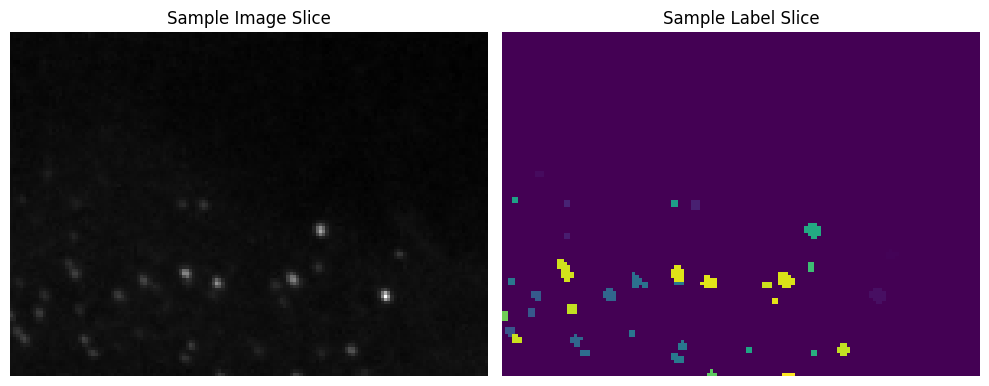

In [7]:
# Visualize a middle slice of the first sample
# Use the arrays we extracted earlier (img_array and label_array from previous cell)
if 'img_array' not in globals() or 'label_array' not in globals():
    # Fallback: extract from sample_data if arrays weren't set
    img_data = sample_data.get('image', sample_data.get('image'))
    label_data = sample_data.get('label', sample_data.get('label'))
    
    if isinstance(img_data, tuple):
        img_array = img_data[0]
    else:
        img_array = img_data
    
    if isinstance(label_data, tuple):
        label_array = label_data[0]
    else:
        label_array = label_data

img_shape = img_array.shape
label_shape = label_array.shape

print(f"Image shape: {img_shape}")
print(f"Label shape: {label_shape}")

if len(img_shape) == 3:
    # 3D volume, show middle slice
    mid_slice = img_shape[0] // 2
    img_slice = img_array[mid_slice]
    if len(label_shape) == 3:
        label_slice = label_array[mid_slice]
    else:
        label_slice = label_array[0, mid_slice] if label_shape[0] == 1 else label_array[mid_slice]
elif len(img_shape) == 4:
    # 4D with channel, use first channel and middle spatial slice
    # Shape is (C, D, H, W) or (C, H, W, D) - assume (C, D, H, W)
    mid_slice = img_shape[1] // 2  # Middle slice in depth dimension
    img_slice = img_array[0, mid_slice]  # First channel, middle depth slice
    if len(label_shape) == 4:
        label_slice = label_array[0, mid_slice]  # First channel, middle depth slice
    else:
        label_slice = label_array[mid_slice]
else:
    img_slice = img_array
    label_slice = label_array

# Convert to numpy if needed
if hasattr(img_slice, 'numpy'):
    img_slice = img_slice.numpy()
elif hasattr(img_slice, 'cpu'):
    img_slice = img_slice.cpu().numpy()
if hasattr(label_slice, 'numpy'):
    label_slice = label_slice.numpy()
elif hasattr(label_slice, 'cpu'):
    label_slice = label_slice.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_slice, cmap='gray')
axes[0].set_title('Sample Image Slice')
axes[0].axis('off')

axes[1].imshow(label_slice, cmap='viridis')
axes[1].set_title('Sample Label Slice')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 4. Model Selection (Baseline vs SwiGLU+ReLU²)


In [8]:
# Verify model is in MODEL_LIST
available_models = list(config.MODEL_LIST.keys())
print(f"Available models: {available_models}")

if MODEL_NAME not in config.MODEL_LIST:
    raise ValueError(
        f"Model '{MODEL_NAME}' not found in MODEL_LIST. Available: {available_models}"
    )

# Create ModelInfo
model_info = config.ModelInfo(name=MODEL_NAME)
print(f"\nSelected model: {MODEL_NAME}")
print(f"Model class: {model_info.get_model()}")


Available models: ['SegResNet', 'VNet', 'TRAILMAP_MS', 'SwinUNetR', 'SwinUNetR_SwiGLU_ReLU2', 'WNet3D']

Selected model: SwinUNetR
Model class: <class 'napari_cellseg3d.code_models.models.model_SwinUNetR.SwinUNETR_'>


## 5. Training Configuration


In [9]:
# Training hyperparameters
TRAINING_CONFIG = {
    "max_epochs": 50,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "num_workers": 2,  # Adjust based on your system
    "training_percent": 0.8,  # 80% train, 20% validation
    "validation_interval": 2,  # Validate every N epochs
    "sampling": True,  # Use patch-based sampling
    "num_samples": 2,  # Number of patches per image
    "sample_size": [64, 64, 64],  # Patch size [Z, Y, X]
    "do_augmentation": True,  # Enable data augmentation
    "loss_function": "DiceCE",  # Options: "Dice", "Generalized Dice", "DiceCE", "Tversky"
    "scheduler_factor": 0.5,  # LR reduction factor
    "scheduler_patience": 10,  # Epochs to wait before reducing LR
    "deterministic": True,
    "seed": 34936339,
    "use_pretrained": False,  # Set to True to use pretrained weights
}

print("Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")


Training Configuration:
  max_epochs: 50
  learning_rate: 0.001
  batch_size: 1
  num_workers: 2
  training_percent: 0.8
  validation_interval: 2
  sampling: True
  num_samples: 2
  sample_size: [64, 64, 64]
  do_augmentation: True
  loss_function: DiceCE
  scheduler_factor: 0.5
  scheduler_patience: 10
  deterministic: True
  seed: 34936339
  use_pretrained: False


In [10]:
# Create training configuration
from napari_cellseg3d import config as cellseg3d_config
import numpy as np

# Create weights info
weights_info = cellseg3d_config.WeightsInfo(
    use_pretrained=TRAINING_CONFIG["use_pretrained"],
    use_custom=False,
    path=None,
)

# Create deterministic config
deterministic_config = cellseg3d_config.DeterministicConfig(
    enabled=TRAINING_CONFIG["deterministic"],
    seed=TRAINING_CONFIG["seed"],
)

# Create supervised training worker config
worker_config = cellseg3d_config.SupervisedTrainingWorkerConfig(
    device=str(device),
    model_info=model_info,
    weights_info=weights_info,
    train_data_dict=train_data_dict,
    training_percent=TRAINING_CONFIG["training_percent"],
    max_epochs=TRAINING_CONFIG["max_epochs"],
    loss_function=TRAINING_CONFIG["loss_function"],
    learning_rate=np.float64(TRAINING_CONFIG["learning_rate"]),
    scheduler_factor=TRAINING_CONFIG["scheduler_factor"],
    scheduler_patience=TRAINING_CONFIG["scheduler_patience"],
    validation_interval=TRAINING_CONFIG["validation_interval"],
    batch_size=TRAINING_CONFIG["batch_size"],
    results_path_folder=str(MODELS_DIR),
    sampling=TRAINING_CONFIG["sampling"],
    num_samples=TRAINING_CONFIG["num_samples"],
    sample_size=TRAINING_CONFIG["sample_size"],
    do_augmentation=TRAINING_CONFIG["do_augmentation"],
    num_workers=TRAINING_CONFIG["num_workers"],
    deterministic_config=deterministic_config,
)

print("✓ Training configuration created")


✓ Training configuration created


### WandB Configuration (Optional)


In [11]:
if USE_WANDB:
    try:
        import wandb
        
        # Initialize wandb (will be configured in worker)
        wandb_config = cellseg3d_config.WandBConfig(
            mode="online",  # or "offline" or "disabled"
            save_model_artifact=False,
        )
        print("✓ WandB will be enabled during training")
        print("  Make sure to run: wandb.login() before training")
    except ImportError:
        print("⚠ WandB not installed. Install with: pip install wandb")
        USE_WANDB = False
else:
    wandb_config = cellseg3d_config.WandBConfig(
        mode="disabled",
        save_model_artifact=False,
    )
    print("✓ WandB disabled")


✓ WandB disabled


## 6. Training Loop


### Understanding TrainingReport Structure

The `SupervisedTrainingWorker.train()` method is a generator that yields `TrainingReport` objects.

**TrainingReport structure:**
- `epoch`: int - Current epoch number
- `loss_1_values`: dict - Training loss history, e.g., `{"Loss": [0.1, 0.2, 0.3, ...]}`
- `loss_2_values`: list - Validation Dice scores, e.g., `[0.5, 0.6, 0.7, ...]`
- `weights`: dict - Model state dict (for saving checkpoints)
- `images_dict`: dict - Validation images for visualization
- `supervised`: bool - Always True for supervised training

**When reports are yielded:**
- Reports are yielded at validation intervals (every `validation_interval` epochs)
- Also yielded at the final epoch
- Each report contains cumulative history up to that point


In [12]:
# Create training worker
worker = SupervisedTrainingWorker(worker_config=worker_config)

# Set WandB config if enabled
if USE_WANDB:
    worker.wandb_config = wandb_config

print(f"✓ Training worker created for model: {MODEL_NAME}")
print(f"  Device: {device}")
print(f"  Max epochs: {TRAINING_CONFIG['max_epochs']}")
print(f"  Validation interval: {TRAINING_CONFIG['validation_interval']}")


✓ Training worker created for model: SwinUNetR
  Device: cpu
  Max epochs: 50
  Validation interval: 2


In [13]:
# Run training
print("Starting training...")
print("=" * 60)

history = []
training_losses = []
validation_dice = []
epochs = []

try:
    for epoch_report in worker.train():
        # Extract information from report
        epoch = epoch_report.epoch
        
        # Get training losses (cumulative list)
        if epoch_report.loss_1_values and "Loss" in epoch_report.loss_1_values:
            loss_history = epoch_report.loss_1_values["Loss"]
            current_loss = loss_history[-1] if loss_history else None
            training_losses = loss_history.copy()
        else:
            current_loss = None
        
        # Get validation dice (cumulative list)
        if epoch_report.loss_2_values:
            dice_history = epoch_report.loss_2_values
            current_dice = dice_history[-1] if dice_history else None
            validation_dice = dice_history.copy()
        else:
            current_dice = None
        
        # Store epoch info
        epochs.append(epoch)
        
        # Print progress
        print(f"\nEpoch {epoch + 1}/{TRAINING_CONFIG['max_epochs']}")
        if current_loss is not None:
            print(f"  Training Loss: {current_loss:.4f}")
        if current_dice is not None:
            print(f"  Validation Dice: {current_dice:.4f}")
        
        # Store full report
        history.append({
            "epoch": epoch,
            "train_loss": current_loss,
            "val_dice": current_dice,
            "loss_history": training_losses.copy() if training_losses else [],
            "dice_history": validation_dice.copy() if validation_dice else [],
        })
        
        print("-" * 60)

except KeyboardInterrupt:
    print("\n⚠ Training interrupted by user")
except Exception as e:
    print(f"\n✗ Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)


Starting training...
2025-12-02 20:44:01,196 - ERROR - Error in training
Traceback (most recent call last):
  File "/Users/shreyessridhara/Downloads/segmentation_case_study/cellseg3d/napari_cellseg3d/code_models/worker_training.py", line 1204, in train
    if check_labels["label"].max() > 1:
       ^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'tuple' object has no attribute 'max'
2025-12-02 20:44:01,203 - ERROR - 'tuple' object has no attribute 'max'
Traceback (most recent call last):
  File "/Users/shreyessridhara/Downloads/segmentation_case_study/cellseg3d/napari_cellseg3d/code_models/worker_training.py", line 1204, in train
    if check_labels["label"].max() > 1:
       ^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'tuple' object has no attribute 'max'

Training completed!


In [14]:
# Extract final metrics
if history:
    final_report = history[-1]
    final_losses = final_report["loss_history"]
    final_dice = final_report["dice_history"]
    
    print(f"Final Training Loss: {final_losses[-1]:.4f}" if final_losses else "N/A")
    print(f"Final Validation Dice: {final_dice[-1]:.4f}" if final_dice else "N/A")
    
    if final_dice:
        best_dice = max(final_dice)
        best_epoch = final_dice.index(best_dice) * TRAINING_CONFIG["validation_interval"]
        print(f"Best Validation Dice: {best_dice:.4f} at epoch {best_epoch + 1}")
else:
    print("No training history available")


No training history available


In [15]:
# Plot training loss
if training_losses:
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(training_losses) + 1), training_losses, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss - {MODEL_NAME}')
    plt.grid(True, alpha=0.3)
    
    # Plot validation dice if available
    if validation_dice:
        plt.subplot(1, 2, 2)
        dice_epochs = [(i + 1) * TRAINING_CONFIG["validation_interval"] 
                      for i in range(len(validation_dice))]
        plt.plot(dice_epochs, validation_dice, 'g-', linewidth=2, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Validation Dice')
        plt.title(f'Validation Dice - {MODEL_NAME}')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = RESULTS_DIR / f"{MODEL_NAME}_training_curves.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"✓ Plot saved to: {plot_path}")
    
    plt.show()
else:
    print("No training data to plot")


No training data to plot


## 8. Qualitative Outputs (Optional)


In [16]:
# Load the best model checkpoint and run inference on a validation sample
if history and validation_dice:
    # Find best model checkpoint
    best_model_path = MODELS_DIR / f"{MODEL_NAME}_best_metric.pth"
    
    if best_model_path.exists():
        print(f"Loading best model from: {best_model_path}")
        
        # Get a validation sample
        val_idx = int(len(train_data_dict) * TRAINING_CONFIG["training_percent"])
        val_sample = train_data_dict[val_idx] if val_idx < len(train_data_dict) else train_data_dict[0]
        
        # Load image and label
        loader = LoadImaged(keys=["image", "label"])
        val_data = loader(val_sample)
        
        # Load model (simplified - in practice, you'd need to instantiate with correct size)
        print("Note: Full inference requires model instantiation with correct input size.")
        print("This is a placeholder for qualitative evaluation.")
        print(f"Validation sample: {Path(val_sample['image']).name}")
    else:
        print(f"Best model checkpoint not found at: {best_model_path}")
else:
    print("No training history available for inference")


No training history available for inference


## 9. Saving Results


In [17]:
# Save training history
if history:
    # Save as JSON (convert numpy types to native Python types)
    history_json = []
    for h in history:
        history_json.append({
            "epoch": int(h["epoch"]),
            "train_loss": float(h["train_loss"]) if h["train_loss"] is not None else None,
            "val_dice": float(h["val_dice"]) if h["val_dice"] is not None else None,
            "loss_history": [float(x) for x in h["loss_history"]],
            "dice_history": [float(x) for x in h["dice_history"]],
        })
    
    json_path = RESULTS_DIR / f"{MODEL_NAME}_training_history.json"
    with open(json_path, 'w') as f:
        json.dump(history_json, f, indent=2)
    print(f"✓ Training history saved to: {json_path}")
    
    # Also save as pickle for full Python object preservation
    pickle_path = RESULTS_DIR / f"{MODEL_NAME}_training_history.pkl"
    with open(pickle_path, 'wb') as f:
        pickle.dump(history, f)
    print(f"✓ Training history (pickle) saved to: {pickle_path}")
    
    # Save configuration
    config_dict = {
        "model_name": MODEL_NAME,
        "training_config": TRAINING_CONFIG,
        "device": str(device),
        "dataset_size": len(train_data_dict),
    }
    config_path = RESULTS_DIR / f"{MODEL_NAME}_config.json"
    with open(config_path, 'w') as f:
        json.dump(config_dict, f, indent=2)
    print(f"✓ Configuration saved to: {config_path}")
    
    print(f"\nAll results saved to: {RESULTS_DIR}")
else:
    print("No training history to save")


No training history to save
